In [88]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame, get_mesh_from_bm_image, get_tissue_curvatures
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model
from skimage import io
import pyvista as pv
from trimesh import smoothing, Trimesh, proximity
from trimesh.curvature import discrete_mean_curvature_measure,sphere_ball_intersection

import ipyvolume as ipv
import stackview

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [321]:
dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R2/'

basals = pd.read_csv(path.join(dirname,'Mastodon/single_timepoints.csv'),index_col=0)
B = io.imread(path.join(dirname,'Cropped_images/B.tif'))
G = io.imread(path.join(dirname,'Cropped_images/G.tif'))
R = io.imread(path.join(dirname,'Cropped_images/R.tif'))

In [322]:
# Load height images
bm_maps = [io.imread(path.join(dirname,f'Image flattening/heightmaps/t{t}.tif')) for t in range(15)]
bm_images = [io.imread(path.join(dirname,f'Image flattening/height_image/t{t}.tif')) for t in range(15)]
mean_bm_height = np.stack([bm.mean() for bm in bm_maps]).round().astype(int)
mean_bm_height

array([57, 58, 59, 60, 59, 60, 60, 60, 61, 60, 60, 60, 60, 60, 60])

In [323]:
# Get meshes
# from trimesh import Trimesh
from measurements import get_tissue_curvatures,get_mesh_from_bm_image

bm_meshes = [get_mesh_from_bm_image(bm) for bm in tqdm(bm_images)]
mean_curvatures = [get_tissue_curvatures(mesh)[0] for mesh in tqdm(bm_meshes)]

100%|████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:58<00:00,  7.93s/it]


In [324]:
def interpolate_curvature_on_image_grid(mesh,curvature,grid_shape):
    
    from scipy.interpolate import LinearNDInterpolator
    
    micron_Xmin,micron_Xmax = mesh.vertices[:,1].min(),mesh.vertices[:,1].max()
    micron_Ymin,micron_Ymax = mesh.vertices[:,0].min(),mesh.vertices[:,0].max()
        
    NXgrid = grid_shape[1]
    micron_gridX = np.linspace(0,micron_Xmax,NXgrid)
    NYgrid = grid_shape[0]
    micron_gridY = np.linspace(0,micron_Ymax,NYgrid)
    micron_gridXX,micron_gridYY = np.meshgrid( micron_gridX, micron_gridY)

    interp = LinearNDInterpolator(list(zip(mesh.vertices[:,1], mesh.vertices[:,0])), curvature)
    
    interp_curve = interp( micron_gridXX,micron_gridYY )
    return interp_curve


In [326]:
interped_curvatures = np.stack([interpolate_curvature_on_image_grid(bm_meshes[t],mean_curvatures[t],[460,460])
                       for t in range(15)])
# clean up NaNs
interped_curvatures[np.isnan(interped_curvatures)] = 0
stackview.slice(interped_curvatures)

In [192]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(divide_cyto_mesh))
pl.show()

NameError: name 'divide_cyto_mesh' is not defined

In [110]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(diff_cyto_mesh))
pl.show()

Widget(value='<iframe src="http://localhost:54576/index.html?ui=P_0xd18c242b0_14&reconnect=auto" class="pyvist…

In [97]:
pl = pv.Plotter()
pl.add_mesh(pv.wrap(divide_cyto_mesh))
pl.show()

Name                Nuclear volume  Nuclear solidity    Z    Y    X  \
Will differentiate                                                    
False                          336               336  336  336  336   
True                           421               421  421  421  421   

Name                Nuclear height  Cell volume  Z-cyto  Y-cyto  X-cyto  ...  \
Will differentiate                                                       ...   
False                          336          336     336     336     336  ...   
True                           421          421     421     421     421  ...   

Name                Mean adjac cyto_shcoeffs_L2M1S at 1 frame prior  \
Will differentiate                                                    
False                                                           336   
True                                                            421   

Name                Relative Cell volume at 1 frame prior  \
Will differentiate                              

In [327]:
from pystackreg import StackReg
from skimage import transform

# Serially register
# Xtrim = slice(50,400); Ytrim = slice(50,400)
Tmats = []
transformed_curvatures = np.zeros((15,460,460))
transformed_curvatures[0,...] = interped_curvatures[0]

transformed_G = np.zeros((15,460,460))
transformed_G[0,...] = G[0,mean_bm_height[0],...]
for t in tqdm(range(14)):
    target = transformed_curvatures[t,:,:]
    moving = interped_curvatures[t+1][:,:]
    sr = StackReg(StackReg.RIGID_BODY)
    T = sr.register(target,moving)
    T = transform.EuclideanTransform(T)
    Tmats.append(T)
    print(T.translation)
    # print(np.rad2deg(T.rotation))
    transformed_curvatures[t+1,...] = transform.warp(interped_curvatures[t+1],T)
    transformed_G[t+1,...] = transform.warp(G[t+1,mean_bm_height[t+1],...],T)

 14%|████████████▋                                                                            | 2/14 [00:00<00:01,  6.07it/s]

[8.51184967 1.35859154]
[ 8.93740937 -2.86665808]


 29%|█████████████████████████▍                                                               | 4/14 [00:00<00:01,  5.71it/s]

[5.35109142 3.77724906]
[24.25530725 -2.73024518]


 43%|██████████████████████████████████████▏                                                  | 6/14 [00:01<00:01,  5.94it/s]

[7.19029117 2.43288604]
[11.98509987  0.66321633]


 57%|██████████████████████████████████████████████████▊                                      | 8/14 [00:01<00:00,  6.07it/s]

[10.05451304  2.31572234]
[4.15887373 0.73541119]


 71%|██████████████████████████████████████████████████████████████▊                         | 10/14 [00:01<00:00,  5.67it/s]

[9.13769979 5.62923665]
[11.83181594  7.09714823]


 86%|███████████████████████████████████████████████████████████████████████████▍            | 12/14 [00:02<00:00,  5.60it/s]

[14.20964516  4.13049229]
[14.88762643  5.29293304]


 93%|█████████████████████████████████████████████████████████████████████████████████▋      | 13/14 [00:02<00:00,  5.92it/s]

[13.42588537  5.80930242]
[10.89027223  3.67093228]


100%|████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.83it/s]


In [328]:
stackview.switch({'R':np.stack([im[mean_bm_height[t],...] for t,im in enumerate(G)]),
                   'G':interped_curvatures},toggleable=True,
                colormap=['pure_magenta','pure_green'])

In [329]:
stackview.switch({'R':transformed_G,'G':transformed_curvatures},toggleable=True,
                colormap=['pure_magenta','pure_green'])

In [330]:
# Use the Tmats and transform the TZYX coordiantes
from numpy import linalg

TZYX = basals.reset_index()[['TrackID','Frame','Z','Y','X','Mean curvature 5um']]
transformed_coords = TZYX.copy()
for t in range(14):
    Iinframe = TZYX['Frame'] == t+1
    translation = Tmats[t].translation
    transformed_coords.loc[Iinframe,['Y','X']] = TZYX.loc[Iinframe,['Y','X']] + translation
    theta = Tmats[t].rotation
    mat = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    transformed_coords.loc[Iinframe,['Y','X']] = np.dot(mat,TZYX.loc[Iinframe,['Y','X']].T).T


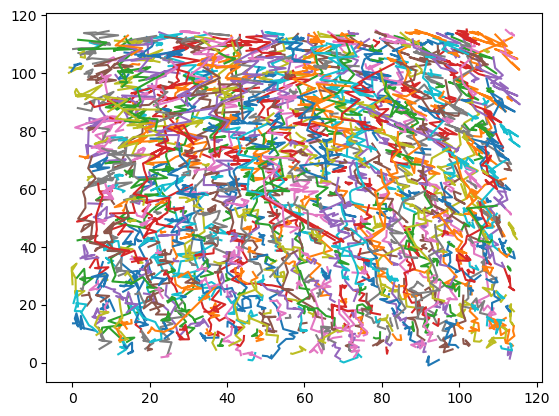

In [331]:
aligned_basals = [track for _,track in transformed_coords.groupby(['TrackID']) if len(track) > 3]
ax = plt.subplots()[1]
for track in aligned_basals:
    track['Vx'] = np.hstack((np.diff(track['X']),np.nan))
    track['Vy'] = np.hstack((np.diff(track['Y']),np.nan))
    ax.plot(track['X'],track['Y'])

transformed_coords = pd.concat(aligned_basals)
transformed_coords['Speed'] = np.sqrt(transformed_coords['X']**2 + transformed_coords['Y']**2)

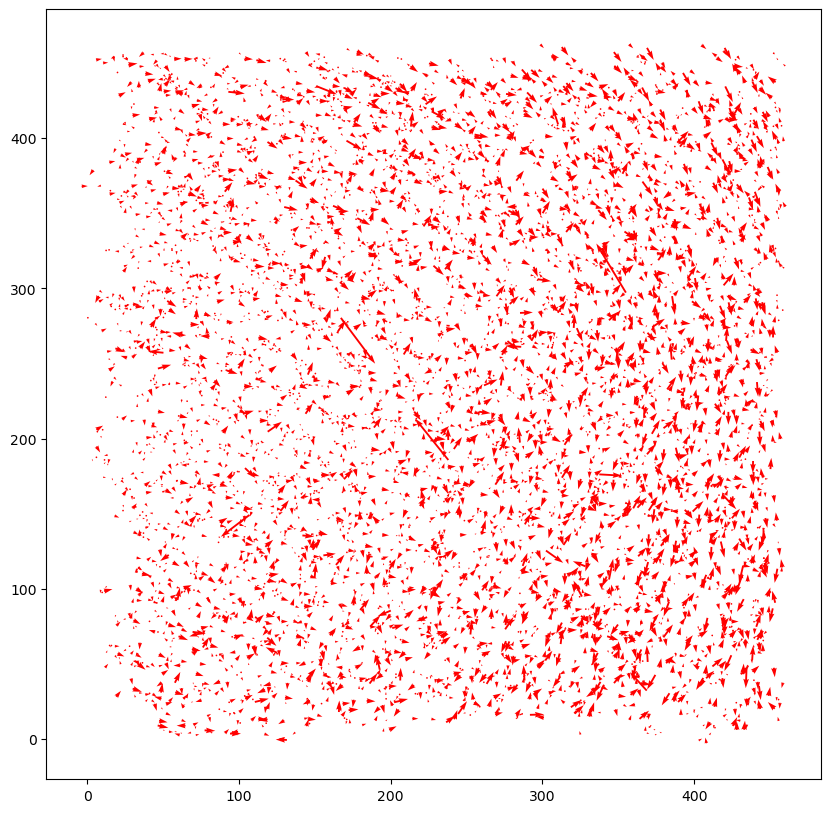

In [348]:
plt.figure(figsize=(10,10))
# plt.imshow(interped_curvatures[14])
# plt.colorbar()

plt.quiver(transformed_coords['Y']*4,transformed_coords['X']*4,
           transformed_coords['Vy']*4,transformed_coords['Vx']*4,color='r')

In [343]:
from scipy.spatial import cKDTree

def calculate_divergence_lsq(points, u,v, k_neighbors=6):

    # Build KD-tree for efficient neighbor search
    tree = cKDTree(points)
    
    # Initialize divergence array
    divergence = np.zeros(len(points))
    
    # Ensure we don't request more neighbors than available points
    k = min(k_neighbors, len(points))
    
    # For each point, fit local plane and extract gradients
    for i, pt in enumerate(points):
        # Find k nearest neighbors (including the point itself)
        distances, indices = tree.query(pt, k=k)

        # Get neighbor coordinates and velocities
        neighbor_points = points[indices,:]
        neighbor_u = u[indices]
        neighbor_v = v[indices]
        
        # Fit plane for u: u = a0 + a1*x + a2*y
        # Design matrix: [1, x, y]
        A = np.c_[np.ones(len(neighbor_points)), neighbor_points]
        
        # Solve least-squares for u component
        try:
            coeffs_u, _, _, _ = np.linalg.lstsq(A, neighbor_u, rcond=None)
            du_dx = coeffs_u[1]
        except np.linalg.LinAlgError:
            du_dx = 0.0
        
        # Solve least-squares for v component
        try:
            coeffs_v, _, _, _ = np.linalg.lstsq(A, neighbor_v, rcond=None)
            dv_dy = coeffs_v[2]
        except np.linalg.LinAlgError:
            dv_dy = 0.0
        
        # Divergence = du/dx + dv/dy
        divergence[i] = du_dx + dv_dy
    
    return divergence


    
points = transformed_coords[['Y','X']].values
u=transformed_coords['Vy'].values
v=transformed_coords['Vx'].values

div = calculate_divergence_lsq(points,u,v)


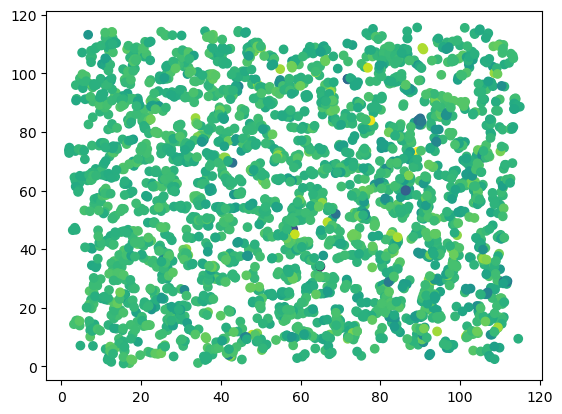

In [344]:
plt.scatter(points[:,0],points[:,1],c=div)

(-20.0, 20.0)

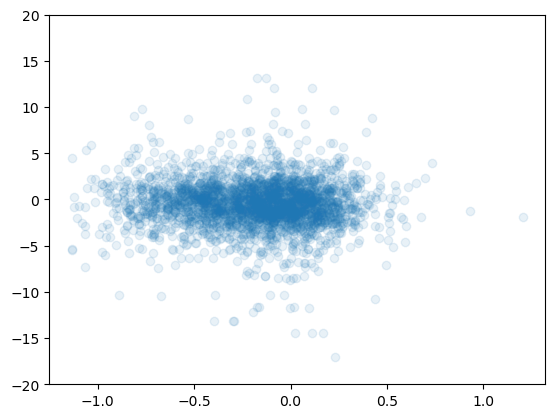

In [345]:
plt.scatter(transformed_coords['Mean curvature 5um'],div,alpha=0.1)
plt.ylim([-20,20])

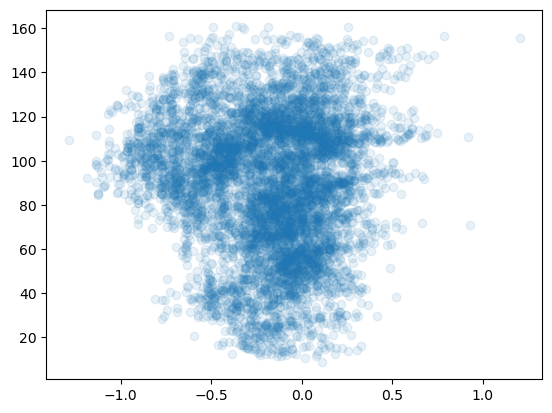

In [346]:
plt.scatter(transformed_coords['Mean curvature 5um'],transformed_coords['Speed'],alpha=0.1)